In [ ]:
!pip install pytesseract
!sudo apt-get install tesseract-ocr-ind

In [ ]:
!pip install PassportEye
# tessaract should also be connected in command line

In [ ]:
%matplotlib inline
from passporteye.mrz.image import MRZPipeline
from matplotlib import pyplot as plt
from random import randint
import cv2
import sys, os, re
import traceback
import pytesseract
import datetime
import pandas as pd


In [ ]:
##############    roots     ##################

pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'
cv2_base_dir = os.path.dirname(os.path.abspath(cv2.__file__))
CASCADE = os.path.join(cv2_base_dir, 'data/haarcascade_frontalface_default.xml')
FACE_CASCADE=cv2.CascadeClassifier(CASCADE)

In [ ]:
#######################  Create   ########################

if not os.path.isdir('Face'):
  !mkdir '/content/Face'


dataset = pd.DataFrame(columns = ["firstname","surname", 'nationality', 'passport_type', 'date_of_birth', 'ID_number', 'gender', 'expiration_date', 'age'])

In [ ]:
######################    Upload Image   ######################
from google.colab import files

files.upload()

In [ ]:
image = '/content/passport2.jpeg'

In [ ]:
#################################   Text Extraction   ########################################

p = MRZPipeline(image)
mrz_data = p.result.to_dict()

if mrz_data['names']:
  firstname =     mrz_data['names'].split()[0]
else:
  firstname = ''
surname   =     mrz_data['surname']
nationality =   mrz_data['nationality']
passport_type = re.sub("[^A-Z^.]", "", mrz_data['type'])
date_of_birth = pd.to_datetime(re.sub("[^0-9^.]", "", mrz_data['date_of_birth']), format='%y%m%d', errors='coerce')
ID_number =     mrz_data['number'].strip().replace('<', '')
gender  =       mrz_data['sex']
expiration_date = mrz_data['expiration_date']

birth = int(re.sub("[^0-9^.]", "", mrz_data['date_of_birth'])[:2])
current = int(str(datetime.datetime.now().year)[2:])

if birth >  current:
  age = current - birth + 100
else:
  age = current - birth

In [ ]:
####################     Save     ######################

dataset.loc[dataset.shape[0]] = [firstname, surname, nationality, passport_type, 
                                 date_of_birth, ID_number, gender, expiration_date, age]

dataset.to_csv('dataset.csv', index=False)

In [ ]:
dataset

,firstname,surname,nationality,passport_type,date_of_birth,ID_number,gender,expiration_date,age
1,ANGELA,ST HELENA SPECIMEN,GBR,P,1988-09-11,760641560,F,250310,33
2,SUNDAL,SHAMIM,PAK,P,1996-09-05,RZ5153771,F,240228,25
3,SEYMOOR,PIPP,OGB,P,NaT,T6TO7TEOP,A,N15051,71


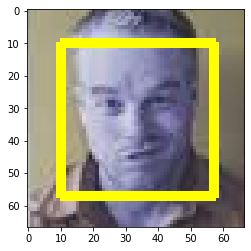

In [ ]:
################    Photo     ########################

def detect_faces(image_path, name='', display=True):
  image=cv2.imread(image_path)
  image_grey=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
  faces = list(FACE_CASCADE.detectMultiScale(image_grey, 
                                             scaleFactor=1.16, minNeighbors=5, minSize=(25,25), flags=0))

  if faces is 0:
    print("No faces found")
    exit()


  x, y, w, h = faces[0]
  face = image[y-10:y+h+10,x-10:x+w+10]
  os.chdir('/content/Face/')
  
  if name:
    cv2.imwrite(name+".jpg",face)
  else:
    cv2.imwrite(str(randint(0,10000))+".jpg",face)
  os.chdir("../")
  cv2.rectangle(image,(x,y),(x+w,y+h),(255, 255,0),2)
  
  if display:
    plt.imshow(face)
    plt.show()


detect_faces(image, firstname)